In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import platform
import os
import time

print('Python ver:', platform.python_version())
print('Scikit-learn ver:', sklearn.__version__)
print('Pandas ver:', pd.__version__)
print('Numpy ver:', np.__version__)

Python ver: 3.7.3
Scikit-learn ver: 1.0.2
Pandas ver: 1.3.5
Numpy ver: 1.19.4


In [2]:
# Read csv and check the data
cwd = os.path.dirname(os.path.abspath('__file__'))
dataset_dir = os.path.join(cwd, '..', '..', 'Transformed dataset')
mean_path = os.path.join(dataset_dir, 'transformed_mean.csv')
var_path = os.path.join(dataset_dir, 'transformed_var.csv')

mean_csv = pd.read_csv(mean_path)
var_csv = pd.read_csv(var_path)

In [3]:
mean_csv = mean_csv.drop(columns=["label"])
mean_csv = mean_csv.add_suffix("_mean")
mean_csv.columns = mean_csv.columns.str.replace("Unnamed: 0_mean", "index")
mean_csv.columns

Index(['index', 'xpos_mean', 'ypos_mean', 'zpos_mean', 'xvel_mean',
       'yvel_mean', 'zvel_mean', 'xacc_mean', 'yacc_mean', 'zacc_mean'],
      dtype='object')

In [4]:
var_csv = var_csv.add_suffix("_var")
var_csv.columns = var_csv.columns.str.replace("Unnamed: 0_var", 'index')
var_csv.columns = var_csv.columns.str.replace("label_var", 'label')
var_csv.columns

Index(['index', 'xpos_var', 'ypos_var', 'zpos_var', 'xvel_var', 'yvel_var',
       'zvel_var', 'xacc_var', 'yacc_var', 'zacc_var', 'label'],
      dtype='object')

In [5]:
merged = mean_csv.merge(var_csv, on='index')
merged.columns

Index(['index', 'xpos_mean', 'ypos_mean', 'zpos_mean', 'xvel_mean',
       'yvel_mean', 'zvel_mean', 'xacc_mean', 'yacc_mean', 'zacc_mean',
       'xpos_var', 'ypos_var', 'zpos_var', 'xvel_var', 'yvel_var', 'zvel_var',
       'xacc_var', 'yacc_var', 'zacc_var', 'label'],
      dtype='object')

In [6]:
merged.head()

,index,xpos_mean,ypos_mean,zpos_mean,xvel_mean,yvel_mean,zvel_mean,xacc_mean,yacc_mean,zacc_mean,xpos_var,ypos_var,zpos_var,xvel_var,yvel_var,zvel_var,xacc_var,yacc_var,zacc_var,label
0,0,-0.132441,1.818894,1.126524,-0.034340,-0.008131,-0.254972,-0.062188,-0.022162,-0.127762,0.001940,0.008719,0.134980,0.010190,0.007413,0.122343,0.010610,0.014236,0.065308,0
1,1,-0.144392,1.793557,1.118971,-0.022590,-0.038763,-0.215774,-0.130912,-0.094322,-0.156462,0.002276,0.010267,0.081638,0.044725,0.012691,0.232494,0.042590,0.039106,0.189655,0
2,2,-0.309730,1.736425,1.058666,0.008053,-0.014171,-0.241596,-0.187329,-0.094175,-0.304099,0.005804,0.017488,0.138591,0.110522,0.009268,0.282040,0.071227,0.039771,0.189879,0
3,3,-0.312120,1.785316,1.098358,-0.016384,-0.023224,-0.176972,-0.147660,-0.086541,-0.152001,0.003112,0.008101,0.095979,0.042904,0.005863,0.110072,0.039747,0.021820,0.072890,0
4,4,-0.231677,1.737191,1.036649,-0.033658,0.015930,-0.182137,-0.022553,0.011463,0.136443,0.000865,0.005119,0.073720,0.003504,0.016209,0.186231,0.003395,0.022270,0.218428,0


In [7]:
features = merged[['zpos_mean', 'zvel_mean', 'zacc_mean', 'zpos_var', 'zvel_var', 'zacc_var']].values
features

array([[ 1.1265242 , -0.25497226, -0.12776197,  0.13498003,  0.1223426 ,
         0.06530786],
       [ 1.1189715 , -0.21577374, -0.15646161,  0.08163802,  0.23249433,
         0.18965507],
       [ 1.05866555, -0.24159624, -0.30409878,  0.13859051,  0.28204017,
         0.18987909],
       ...,
       [ 0.79370929, -0.9626039 , -1.42506593,  0.42752325,  1.82867887,
         2.42943007],
       [ 0.64153709, -0.49248116, -0.27924988,  0.29981829,  0.47891933,
         0.5645309 ],
       [ 0.69740668, -0.57548087, -0.39879246,  0.38606245,  0.49536894,
         0.62464408]])

In [8]:
X = features
Y = merged['label'].values

In [9]:
model_to_evaluate = []
model_to_evaluate.append(('KNN', KNeighborsClassifier(), 'K-nearest Neighbor'))
model_to_evaluate.append(('DT', DecisionTreeClassifier(), 'DecisionTree'))
model_to_evaluate.append(('NB', GaussianNB(), 'Gaussian Naive-Bayes'))
model_to_evaluate.append(('SVM', SVC(), 'Support Vector Machine'))

In [10]:
results=[]
names=[]

for name, model, full_name in model_to_evaluate:
    kfold = StratifiedKFold(n_splits=3, random_state=1, shuffle=True)
    cv_result = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
    results.append(cv_result)
    names.append(name)
    print(f'Akurasi {name}: {cv_result.mean()} dengan std dev {cv_result.std()}')
    print()

Akurasi KNN: 0.9616083095253914 dengan std dev 0.0257909781842823

Akurasi DT: 0.9519633246960334 dengan std dev 0.014985891608957113

Akurasi NB: 0.9211458817797267 dengan std dev 0.00988309991897218

Akurasi SVM: 0.9673665094235155 dengan std dev 0.02162679035321287



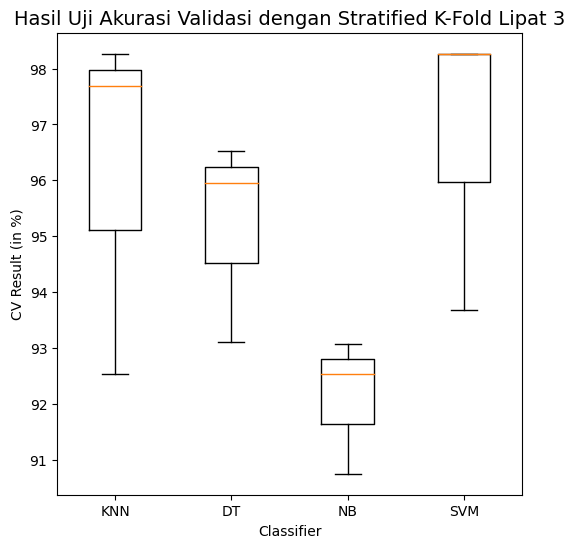

In [11]:
plt.figure(figsize=(6,6))
plt.boxplot(list(map(lambda item: item*100, results)), labels=names)
plt.title('Hasil Uji Akurasi Validasi dengan Stratified K-Fold Lipat 3', fontdict={'fontweight': 'normal', 'fontsize':'14'})
plt.xlabel('Classifier')
plt.ylabel('CV Result (in %)')
# plt.savefig('CV Result.png', dpi=300)
plt.show()


In [12]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.10, random_state=1)

In [13]:
plot_label = ['Tidak Jatuh', 'Jatuh']

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        38
           1       1.00      0.79      0.88        14

    accuracy                           0.94        52
   macro avg       0.96      0.89      0.92        52
weighted avg       0.95      0.94      0.94        52

              precision    recall  f1-score   support

           0       0.90      0.95      0.92        38
           1       0.83      0.71      0.77        14

    accuracy                           0.88        52
   macro avg       0.87      0.83      0.85        52
weighted avg       0.88      0.88      0.88        52

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        38
           1       0.86      0.86      0.86        14

    accuracy                           0.92        52
   macro avg       0.90      0.90      0.90        52
weighted avg       0.92      0.92      0.92        52

              preci

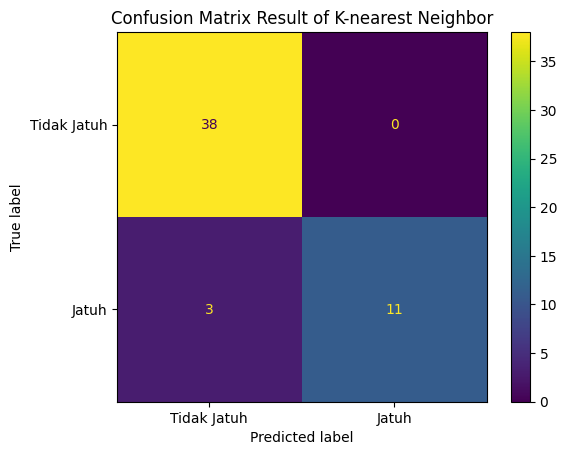

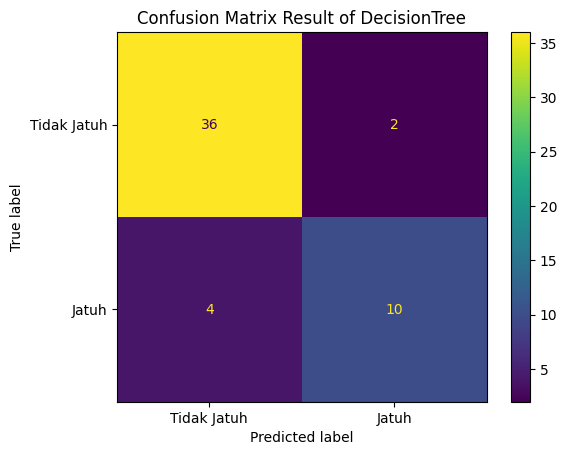

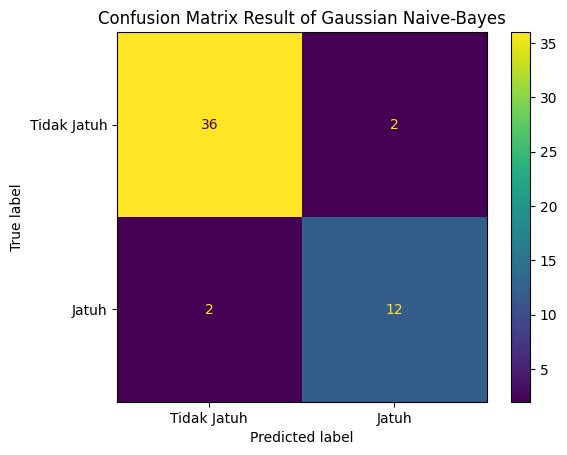

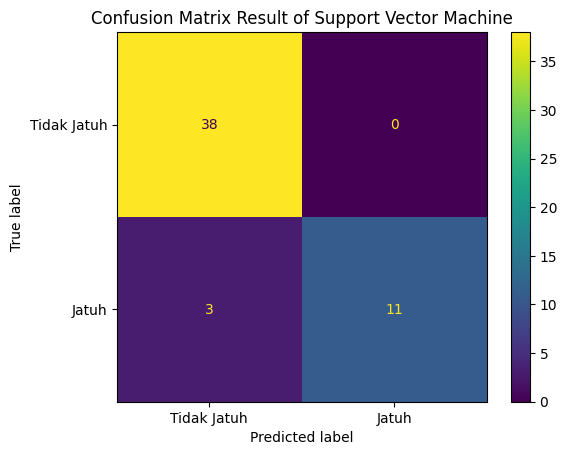

In [14]:
for name, model, full_name in model_to_evaluate:
    clf = model
    clf.fit(X_train, Y_train)
    predictions = clf.predict(X_val)
    print(classification_report(Y_val, predictions))
    disp = ConfusionMatrixDisplay.from_predictions(Y_val, predictions, display_labels=plot_label)
    disp.ax_.set_title(f'Confusion Matrix Result of {full_name}')